In [6]:
# Set up imports and libraries
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
import string
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
#nltk.download('punkt')

In [65]:
# import business dataset
import pandas as pd
yelp_busn = []
r_dtypes = {"stars": np.float16, 
            "latitude": np.int32, 
            "longitude": np.int32,
           }
with open("yelp_academic_dataset_business.json", "r", encoding='utf8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['is_open', 'longitude','latitude','hours'])\
                             .query("`state` == 'FL'")
        yelp_busn.append(reduced_chunk) #`state` == 'FL',
    
yelp_busn = pd.concat(yelp_busn, ignore_index=True) #set index?
#yelp_busn.describe

In [82]:
# limit review set to restaurants in FL for the time period
yelp_busn = yelp_busn[yelp_busn['categories'].str.contains('Restaurant')==True]
yelp_busn

,business_id,name,address,city,state,postal_code,stars,review_count,attributes,categories
2,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,4.0,10,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks"
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,4.5,100,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants"
7,uI9XODGY_2_ieTE6xJ0myw,Roman Forum,10440 N Dale Mabry Hwy,Tampa,FL,33618,4.0,23,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, American (New), Italian"
8,JgpnXv_0XhV3SfbfB50nxw,Joe's Pizza,2038 N Dale Mabry Hwy,Tampa,FL,33607,4.0,35,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Pizza"
12,pJfh3Ct8iL58NZa8ta-a5w,Top Shelf Sports Lounge,3173 Cypress Ridge Blvd,Wesley Chapel,FL,33544,4.5,95,"{'BestNights': '{'monday': False, 'tuesday': F...","Burgers, Sports Bars, Bars, Lounges, Restauran..."
...,...,...,...,...,...,...,...,...,...,...
26315,Scd-rcsQCn60t1sHHFv-og,First Watch,"4045 N Tyrone Blvd, Ste 204",St. Petersburg,FL,33709,3.5,183,"{'RestaurantsPriceRange2': '2', 'OutdoorSeatin...","Cafes, Restaurants, Breakfast & Brunch, Americ..."
26320,8MzF1Tlgz0pOkxmhP5dYzA,El Cap Restaurant,3500 4th St N,St. Petersburg,FL,33704,3.5,414,"{'GoodForKids': 'True', 'BikeParking': 'True',...","American (Traditional), Burgers, Restaurants"
26322,-bZQH8yjm7ntTyGeLQwh8Q,Farmer's Kitchen Restaurant,3500 E Bay Dr,Largo,FL,33771,4.0,6,"{'RestaurantsReservations': 'True', 'Restauran...","Sandwiches, Restaurants, Diners"
26323,BIyT7Kr7tMJqlfp4oOOYQg,Copper Bell Cafe,11228 Boyette Rd,Riverview,FL,33569,3.5,49,"{'BikeParking': 'True', 'RestaurantsReservatio...","Breakfast & Brunch, Cafes, Restaurants"


In [83]:
#import the review data set
yelp_reviews = []
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("yelp_academic_dataset_review.json", "r", encoding='utf8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id', 'user_id','useful','funny','cool'])\
                             .query('date >= "2022-01-01"')
        yelp_reviews.append(reduced_chunk)
        
yelp_reviews = pd.concat(yelp_reviews, ignore_index=True)
#yelp_reviews.describe #80k rows for 12/1/21; 31665  for 2022-01-01

In [89]:
keys = list(yelp_busn['business_id'].values) #business filtered to FL and restaurant
keys
yelp_busn.set_index('business_id') #not a good idea, there are dupes
yelp_reviews.set_index('business_id')
i1 = yelp_reviews.index
i2 = yelp_busn.index
yelp_reviews_FL = yelp_reviews[i1.isin(i2)]
yelp_reviews_FL


,business_id,stars,text,date
2,Jo4ei-c-5H53IxZxAVf1jQ,5.0,Danielle did a great job! She listened and cu...,2022-01-03 03:17:03
4,9MHe5jAym2d8VhT_NbCRyw,2.0,We Ordered pork fried rice and beef chow mei ...,2022-01-06 03:59:21
7,6U0ZweWWWQUzea2rF4zKgQ,5.0,Food was good love the Cuban sandwiche \nThe p...,2022-01-10 19:54:45
8,yYpU8EWucx32OYIIHqP63A,1.0,Have called this location multiple times throu...,2022-01-11 21:07:05
12,LIoU5gBv75l1lMFaQ3wyfQ,5.0,"Excellent, stopped in for a late lunch and was...",2022-01-03 20:37:31
...,...,...,...,...
26315,EhotxJEJxpMgCJ0F82Buvg,2.0,Pretty disappointed in this place. Nice decor ...,2022-01-01 06:46:38
26320,TaYJfvjk0kLMnS-gQd28bw,2.0,Ok place with a nice crowd but servers are poo...,2022-01-06 23:38:54
26322,81dk-1nYjlJDEIG3DRZIwg,4.0,Better if they had food. Decent but not world ...,2022-01-08 20:11:06
26323,6Cs52T0ItZ5TQ5Qx-UGaMw,5.0,Great food. Great service. Two things that ...,2022-01-08 23:08:17


In [90]:
# append text length of review
yelp_reviews_FL.describe
yelp_reviews_FL['text length'] = yelp_reviews_FL['text'].apply(len)
yelp_reviews_FL.head()
yelp_reviews_FL

C:\Users\mcdc9\AppData\Local\Temp/ipykernel_18372/3368109950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_reviews_FL['text length'] = yelp_reviews_FL['text'].apply(len)


,business_id,stars,text,date,text length
2,Jo4ei-c-5H53IxZxAVf1jQ,5.0,Danielle did a great job! She listened and cu...,2022-01-03 03:17:03,278
4,9MHe5jAym2d8VhT_NbCRyw,2.0,We Ordered pork fried rice and beef chow mei ...,2022-01-06 03:59:21,148
7,6U0ZweWWWQUzea2rF4zKgQ,5.0,Food was good love the Cuban sandwiche \nThe p...,2022-01-10 19:54:45,116
8,yYpU8EWucx32OYIIHqP63A,1.0,Have called this location multiple times throu...,2022-01-11 21:07:05,874
12,LIoU5gBv75l1lMFaQ3wyfQ,5.0,"Excellent, stopped in for a late lunch and was...",2022-01-03 20:37:31,317
...,...,...,...,...,...
26315,EhotxJEJxpMgCJ0F82Buvg,2.0,Pretty disappointed in this place. Nice decor ...,2022-01-01 06:46:38,318
26320,TaYJfvjk0kLMnS-gQd28bw,2.0,Ok place with a nice crowd but servers are poo...,2022-01-06 23:38:54,173
26322,81dk-1nYjlJDEIG3DRZIwg,4.0,Better if they had food. Decent but not world ...,2022-01-08 20:11:06,153
26323,6Cs52T0ItZ5TQ5Qx-UGaMw,5.0,Great food. Great service. Two things that ...,2022-01-08 23:08:17,149


In [110]:
# Data Pre Processing
# 1. Remove Stop Words
# 2. Stem
# 3. Tokenize
# 4. Counts
# 5. Replace smileies

#does not filter to restaurants - need business dataset
#createa dataset without 3 stars since those are neutral
yelp_data = yelp_reviews_FL[(yelp_reviews_FL['stars'] > 3) | (yelp_reviews_FL['stars'] < 3)]
#yelp_reviews['label'] = 0

X = pd.DataFrame(yelp_data['text'])
y = pd.DataFrame(yelp_data['stars'])

Xhead = X.head()
Xhead
Yhead = y.head()
Xhead

,text
2,Danielle did a great job! She listened and cu...
4,We Ordered pork fried rice and beef chow mei ...
7,Food was good love the Cuban sandwiche \nThe p...
8,Have called this location multiple times throu...
12,"Excellent, stopped in for a late lunch and was..."


In [111]:
#1 Remove stop words - Done
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Xhead['text'] = Xhead['text'].apply(process_text)
Xhead

C:\Users\mcdc9\AppData\Local\Temp/ipykernel_18372/265175716.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xhead['text'] = Xhead['text'].apply(process_text)


,text
2,"[Danielle, great, job, listened, cut, hair, wa..."
4,"[Ordered, pork, fried, rice, beef, chow, mei, ..."
7,"[Food, good, love, Cuban, sandwiche, place, cl..."
8,"[called, location, multiple, times, throughout..."
12,"[Excellent, stopped, late, lunch, happy, food,..."


In [112]:
# 2 Stem - Done
from nltk.stem.snowball import SnowballStemmer
snowBallStemmer = SnowballStemmer("english")
Xhead['stemmed'] = Xhead['text'].apply(lambda x: [snowBallStemmer.stem(y) for y in x]) # Stem every word.
Xhead = Xhead.drop(columns=['text']) # Get rid of the unstemmed column.
Xhead # Print dataframe.

C:\Users\mcdc9\AppData\Local\Temp/ipykernel_18372/4210125179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xhead['stemmed'] = Xhead['text'].apply(lambda x: [snowBallStemmer.stem(y) for y in x]) # Stem every word.


,stemmed
2,"[daniell, great, job, listen, cut, hair, way, ..."
4,"[order, pork, fri, rice, beef, chow, mei, fun,..."
7,"[food, good, love, cuban, sandwich, place, cle..."
8,"[call, locat, multipl, time, throughout, day, ..."
12,"[excel, stop, late, lunch, happi, food, servic..."


In [113]:
# 3. Tokenize data to turn words into integers for modeling
cv = CountVectorizer() #stop_words=my_stop_words, ngram_range=(2,2
Xhead['stemmed']=[" ".join(review) for review in Xhead['stemmed'].values] #convert from list to text
Xhead_cv = cv.fit_transform(Xhead['stemmed'])

In [114]:
Xhead_cv

<5x120 sparse matrix of type '<class 'numpy.int64'>'
	with 132 stored elements in Compressed Sparse Row format>

<BarContainer object of 10 artists>

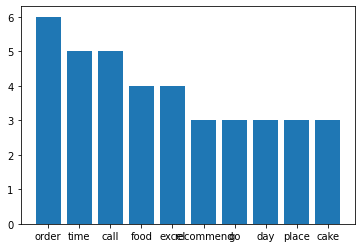

In [115]:
bigram_df = pd.DataFrame(Xhead_cv.toarray(), columns=cv.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(10)
plt.bar(bigram_frequency['bigram'],bigram_frequency['frequency'])

In [116]:
Xhead_cv
print('Shape of Sparse Matrix: ', Xhead_cv.shape)
print('Amount of Non-Zero occurrences: ', Xhead_cv.nnz)
# Percentage of non-zero values
density = (100.0 * Xhead_cv.nnz / (Xhead_cv.shape[0] * Xhead_cv.shape[1]))
print("Density: {}".format((density)))

#graphics
#wordcloud failed
#reviews over time
#dist of star ratings
#length fo text for ratings
#avg monthly rtating

Shape of Sparse Matrix:  (5, 120)
Amount of Non-Zero occurrences:  132
Density: 22.0


In [117]:
# set up nb model and run predictions
X_train, X_test, y_train, y_test = train_test_split(Xhead_cv, Yhead,test_size=0.3,random_state=101)
nb = MultinomialNB()
nb.fit(X_train,y_train)

predictions = nb.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[2]]


              precision    recall  f1-score   support

         5.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [118]:
#nltk.download('vader_lexicon')
# Load SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# Generate sentiment scores
sentiment_scores = Xhead['stemmed'].apply(sid.polarity_scores)
sentiment = sentiment_scores.apply(lambda x: x['compound']) #get compound score
sentiment
#could graph over time

2     0.8625
4     0.5106
7     0.9360
8     0.2561
12    0.9571
Name: stemmed, dtype: float64